Zachary Armand

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from json import load

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam
from torch.nn import functional as F
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.nn import Linear, ReLU, Sequential
from torch.optim.lr_scheduler import CosineAnnealingLR


# Local import
from tools import train_model, evaluate_model, calculate_R2_score, get_predictions, EarlyStopping
from models import SimpleNet, BaseballRNN

In [2]:
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"))
print("Using:", DEVICE)

Using: cuda


In [3]:
#pip freeze > requirements.txt

# Load Data and Create Dataset

In [4]:
input_values = torch.load('./datasets/input_values.pth')
target_values = torch.load('./datasets/target_values.pth')

Dataset and dataloaders are used for both models.

In [5]:
# Create Dataset
dataset = TensorDataset(input_values, target_values)

# Split into test and train data
train_dataset, test_dataset = random_split(dataset, [0.9, 0.1])
train_dataset, valid_dataset = random_split(train_dataset, [0.89, 0.11])
print(f"Train: {len(train_dataset)/len(dataset)*100:.1f}%, Test: {len(test_dataset)/len(dataset)*100:.1f}%, Valid: {len(valid_dataset)/len(dataset)*100:.1f}%")
print(f"Train: {len(train_dataset)}, Test: {len(test_dataset)}, Valid: {len(valid_dataset)}")

# Create consistent test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)
torch.save(test_dataset, './datasets/test_dataset.pth')


Train: 80.1%, Test: 10.0%, Valid: 9.9%
Train: 57640, Test: 7195, Valid: 7123


### Scale Dataset

In [6]:
# Convert datasets to tensors for easier manipulation
train_inputs = torch.stack([x[0] for x in train_dataset])
valid_inputs = torch.stack([x[0] for x in valid_dataset])
test_inputs = torch.stack([x[0] for x in test_dataset])

# Check the shape of the inputs to ensure it's 4D (e.g., (num_samples, channels, height, width))
print(f"Train inputs shape: {train_inputs.shape}")
print(f"Valid inputs shape: {valid_inputs.shape}")
print(f"Test inputs shape: {test_inputs.shape}")

# Store the original shape for later reshaping
original_shape = train_inputs.shape[1:]  # (channels, height, width) or whatever your original shape was

# Reshape the inputs to 2D (samples, features) for scaling
train_inputs_reshaped = train_inputs.view(train_inputs.size(0), -1)
valid_inputs_reshaped = valid_inputs.view(valid_inputs.size(0), -1)
test_inputs_reshaped = test_inputs.view(test_inputs.size(0), -1)

# Scale the inputs using StandardScaler (you could also use MinMaxScaler or another scaler)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Fit scaler on training data and transform
train_inputs_scaled = torch.tensor(scaler.fit_transform(train_inputs_reshaped.numpy()), dtype=torch.float32)

# Use the same scaler to transform the validation and test data
valid_inputs_scaled = torch.tensor(scaler.transform(valid_inputs_reshaped.numpy()), dtype=torch.float32)
test_inputs_scaled = torch.tensor(scaler.transform(test_inputs_reshaped.numpy()), dtype=torch.float32)

# Reshape the scaled inputs back to the original shape (samples, channels, height, width)
train_inputs_scaled = train_inputs_scaled.view(train_inputs.size(0), *original_shape)
valid_inputs_scaled = valid_inputs_scaled.view(valid_inputs.size(0), *original_shape)
test_inputs_scaled = test_inputs_scaled.view(test_inputs.size(0), *original_shape)

# Recreate the datasets with the scaled inputs
train_dataset = TensorDataset(train_inputs_scaled, torch.stack([x[1] for x in train_dataset]))
valid_dataset = TensorDataset(valid_inputs_scaled, torch.stack([x[1] for x in valid_dataset]))
test_dataset = TensorDataset(test_inputs_scaled, torch.stack([x[1] for x in test_dataset]))

# Create consistent test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

Train inputs shape: torch.Size([57640, 9, 15])
Valid inputs shape: torch.Size([7123, 9, 15])
Test inputs shape: torch.Size([7195, 9, 15])


# Linear model

In [7]:
# Get best hyperparameters from tuning
with open('./tuning/mlp_best_params.json', 'r') as file:
    best_mlp_params = load(file)

# Get best hyperparameters from tuning
batch_size = int(best_mlp_params['batch_size'])
lr = best_mlp_params['lr']
grad_clip = best_mlp_params['grad_clip']
weight_decay = best_mlp_params['weight_decay']
hidden_size = int(best_mlp_params['hidden_size'])
mlp_dropout = best_mlp_params['mlp_dropout']

# Print hyperparameters
print("Best hyperparameters:", best_mlp_params)

Best hyperparameters: {'batch_size': 256.0, 'lr': 0.001, 'mlp_dropout': 0.5, 'weight_decay': 0.001, 'hidden_size': 16.0, 'grad_clip': nan}


In [8]:
num_epochs = 250
early_stop_patience = 15

# Turn dataset into Dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

# Create model object
in_features, seq_len = train_dataloader.dataset[0][0].shape
simple_baseball_mlp = SimpleNet(in_features=in_features, seq_len=seq_len, hidden_features=hidden_size, dropout=mlp_dropout).to(DEVICE)

# Print trainable parameters
trainable_params = sum(p.numel() for p in simple_baseball_mlp.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params:,}")

# Optimizer and scheduler
optimizer = optim.Adam(simple_baseball_mlp.parameters(), lr=lr, weight_decay=weight_decay)
early_stopper = EarlyStopping(patience=early_stop_patience, min_delta=0.0001)

# Training logs
mlp_log = []
mlp_eval_log = []
mlp_grads = []

# Loop
pbar = tqdm(range(num_epochs), desc="Training MLP")
for epoch in pbar:
    # Get average loss over batches for training
    avg_train_loss = train_model(simple_baseball_mlp, optimizer, train_dataloader, DEVICE, loss_fn='MSE', grad_clip=grad_clip)
    mlp_log.append(avg_train_loss)

    # Validation loss
    avg_valid_loss = evaluate_model(model=simple_baseball_mlp, data_loader=valid_dataloader, device=DEVICE, loss_fn='MSE')
    mlp_eval_log.append(avg_valid_loss)

    # Track gradients across training
    grads = {n:p.grad.cpu() for n, p in simple_baseball_mlp.named_parameters()}
    mlp_grads.append(grads)

    # Early Stopping
    early_stopper(avg_valid_loss)
    if early_stopper.early_stop:
        print(f"Early stopping at epoch {epoch}")
        break

    # Update progress bar
    #'LR': current_lr[0],
    pbar.set_postfix({'Train loss': avg_train_loss, 'Validation loss': avg_valid_loss, 'ES Counter': early_stopper.counter})

Trainable parameters: 2,529


Training MLP:  18%|█▊        | 44/250 [00:38<02:59,  1.15it/s, Train loss=0.135, Validation loss=0.135, ES Counter=15]

Early stopping at epoch 44


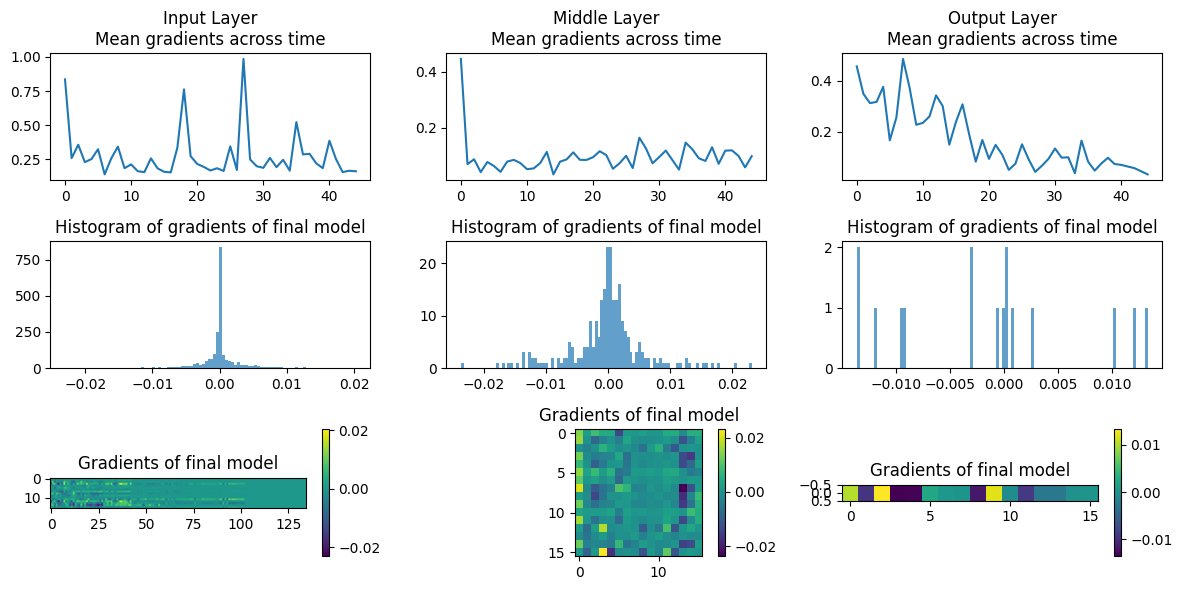

In [9]:
input_layer_grad_norm = [torch.norm(mlp_grads[i]['input_layer.weight']).item() for i in range(len(mlp_grads))]
middle_layer_grad_norm = [torch.norm(mlp_grads[i]['middle_layer.weight']).item() for i in range(len(mlp_grads))]
output_layer_grad_norm = [torch.norm(mlp_grads[i]['output_layer.weight']).item() for i in range(len(mlp_grads))]

# Create a figure and subplots (3 row, 3 columns)
fig, axs = plt.subplots(3, 3, figsize=(12, 6))
axs[0, 0].plot(input_layer_grad_norm)
axs[0, 0].set_title('Input Layer\nMean gradients across time')
axs[0, 1].plot(middle_layer_grad_norm)
axs[0, 1].set_title('Middle Layer\nMean gradients across time')
axs[0, 2].plot(output_layer_grad_norm)
axs[0, 2].set_title('Output Layer\nMean gradients across time')
# Gradient histogram at end of training
i = 0
axs[1, 0].hist(grads['input_layer.weight'].flatten().cpu().numpy(), bins=100, alpha=0.7)
axs[1, 1].hist(grads['middle_layer.weight'].flatten().cpu().numpy(), bins=100, alpha=0.7)
axs[1, 2].hist(grads['output_layer.weight'].flatten().cpu().numpy(), bins=100, alpha=0.7)
axs[1, 0].set_title('Histogram of gradients of final model')
axs[1, 1].set_title('Histogram of gradients of final model')
axs[1, 2].set_title('Histogram of gradients of final model')

# Gradients
grads = {n:p.grad.cpu() for n, p in simple_baseball_mlp.named_parameters()}
im1 = axs[2, 0].imshow(grads['input_layer.weight'])
im2 = axs[2, 1].imshow(grads['middle_layer.weight'])
im3 = axs[2, 2].imshow(grads['output_layer.weight'])
axs[2, 0].set_title('Gradients of final model')
axs[2, 1].set_title('Gradients of final model')
axs[2, 2].set_title('Gradients of final model')
fig.colorbar(im1, ax=axs[2, 0])
fig.colorbar(im2, ax=axs[2, 1])
fig.colorbar(im3, ax=axs[2, 2])

plt.tight_layout()
plt.show()

In [10]:
# Evaluate model - 
mlp_test_RMSE = evaluate_model(model=simple_baseball_mlp, data_loader=test_dataloader, device=DEVICE, loss_fn='RMSE')
mlp_test_MSE = evaluate_model(model=simple_baseball_mlp, data_loader=test_dataloader, device=DEVICE, loss_fn='MSE')
mlp_test_MAE = evaluate_model(model=simple_baseball_mlp, data_loader=test_dataloader, device=DEVICE, loss_fn='MAE')

# Get predictions
mlp_targets, mlp_predictions = get_predictions(simple_baseball_mlp, test_dataloader, DEVICE)
mlp_test_r2 = calculate_R2_score(mlp_targets, mlp_predictions)

print(f'Test RMSE: {mlp_test_RMSE:.4f}, Test MSE: {mlp_test_MSE:.4f}, Test MAE: {mlp_test_MAE:.4f}, Test R2: {mlp_test_r2:.2f}')

Test RMSE: 0.3507, Test MSE: 0.1281, Test MAE: 0.2706, Test R2: 0.09


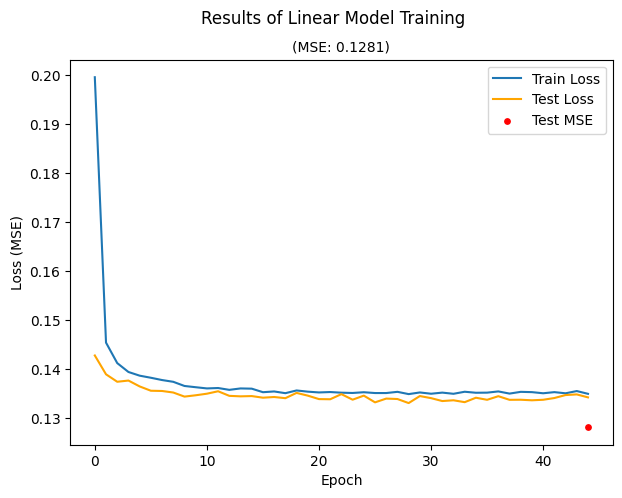

In [11]:
loss = 'MSE'
loss_val = mlp_test_MSE


# Plot loss over time, final test stats
plt.figure(figsize=(7, 5))
plt.suptitle("Results of Linear Model Training")
plt.title(f"({loss}: {loss_val:.4})", size=10)
plt.ylabel(f'Loss ({loss})')
plt.xlabel('Epoch')
plt.plot(mlp_log[:], label='Train Loss')
plt.plot(mlp_eval_log[:], label='Test Loss', color='orange')
plt.scatter(x=len(mlp_log)-1, y=loss_val, color='r', label=f"Test {loss}", s=15)
plt.legend()
plt.show()

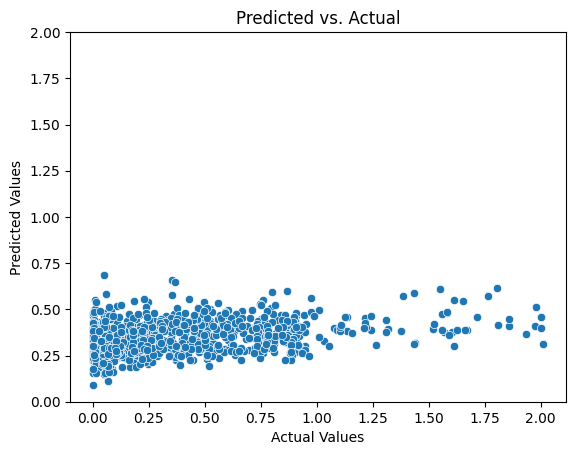

In [12]:
# Plot predicted vs. actual
plt.title("Predicted vs. Actual")
plt.ylabel("Predicted Values")
plt.xlabel("Actual Values")
sns.scatterplot(x=mlp_targets[0:1000], y=mlp_predictions[0:1000])
plt.ylim(0.0, 2.0)
plt.show()

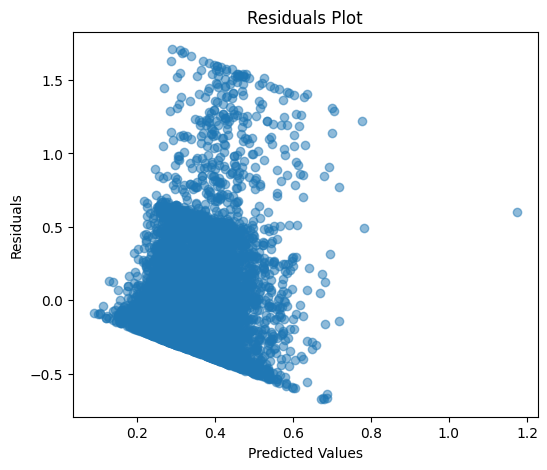

In [13]:
# Plot residuals
plt.figure(figsize=(6, 5))
plt.title("Residuals Plot")
plt.ylabel("Residuals")
plt.xlabel("Predicted Values")
residuals = np.array(mlp_targets) - np.array(mlp_predictions)
plt.scatter(mlp_predictions, residuals, alpha=0.5) 
plt.show()

# RNN model

In [14]:
# Get best hyperparameters from tuning
with open('./tuning/rnn_best_params.json', 'r') as file:
    rnn_best_params = load(file)

# Get best hyperparameters from tuning
batch_size = int(rnn_best_params['batch_size'])
lr = rnn_best_params['lr']
grad_clip = rnn_best_params['grad_clip']
weight_decay = rnn_best_params['weight_decay']
hidden_size = int(rnn_best_params['hidden_size'])
rnn_dropout = rnn_best_params['rnn_dropout']
n_layers = int(rnn_best_params['n_layers'])

# Print hyperparameters
print("Best hyperparameters:", rnn_best_params)

Best hyperparameters: {'batch_size': 64.0, 'n_layers': 2.0, 'lr': 0.001, 'rnn_dropout': 0.5, 'weight_decay': 0.0001, 'grad_clip': 2.0, 'hidden_size': 256.0}


In [15]:
num_epochs = 500
early_stop_patience = 15

# Turn dataset into Dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

# Create model object
input_size = train_dataloader.dataset[0][0].size()[1]
baseball_rnn = BaseballRNN(input_size=input_size, output_size=1, hidden_size=hidden_size,
                                n_layers=n_layers, hidden_init='xavier', rnn_dropout=rnn_dropout).to(DEVICE)

# Print trainable parameters
trainable_params = sum(p.numel() for p in baseball_rnn.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params:,}")

# Optimizer and loss
optimizer = Adam(baseball_rnn.parameters(), lr=lr, weight_decay=weight_decay, betas=[0.9, 0.99])
early_stopper = EarlyStopping(patience=early_stop_patience, min_delta=0.0001)

# Training
rnn_log = []
rnn_eval_log = []
rnn_grads = []

# Training loop
pbar = tqdm(range(num_epochs), desc="Training MLP")
for epoch in pbar:
    # Get average loss over batches for training
    avg_train_loss = train_model(baseball_rnn, optimizer, train_dataloader, DEVICE, loss_fn='MSE', grad_clip=grad_clip)
    rnn_log.append(avg_train_loss)

    # Validation loss
    avg_valid_loss = evaluate_model(model=baseball_rnn, data_loader=valid_dataloader, device=DEVICE, loss_fn='MSE')
    rnn_eval_log.append(avg_valid_loss)

    # Track gradients across training
    grads = {n:p.grad.cpu() for n, p in baseball_rnn.named_parameters()}
    rnn_grads.append(grads)

    # Early Stopping
    early_stopper(avg_valid_loss)
    if early_stopper.early_stop:
        print(f"Early stopping at epoch {epoch}")
        break

    # Update progress bar
    pbar.set_postfix({'Train loss': avg_train_loss, 'Validation loss': avg_valid_loss, 'ES Counter': early_stopper.counter})

Trainable parameters: 794,369


Training MLP:   8%|▊         | 41/500 [05:54<1:06:05,  8.64s/it, Train loss=0.131, Validation loss=0.133, ES Counter=15]

Early stopping at epoch 41


In [27]:
# Evaluate model
rnn_test_RMSE = evaluate_model(model=baseball_rnn, data_loader=test_dataloader, device=DEVICE, loss_fn='RMSE')
rnn_test_MSE = evaluate_model(model=baseball_rnn, data_loader=test_dataloader, device=DEVICE, loss_fn='MSE')
rnn_test_accuracy_MAE = evaluate_model(model=baseball_rnn, data_loader=test_dataloader, device=DEVICE, loss_fn='MAE')
# Get predictions
rnn_targets, rnn_predictions = get_predictions(baseball_rnn, test_dataloader, DEVICE)
rnn_test_r2 = calculate_R2_score(rnn_targets, rnn_predictions)

print(f'Test RMSE: {rnn_test_RMSE:.4f}, Test MSE: {rnn_test_MSE:.4f}, Test MAE: {rnn_test_accuracy_MAE:.4f} Test R2: {rnn_test_r2:.2f}')

Test RMSE: 0.3490, Test MSE: 0.1265, Test MAE: 0.2647 Test R2: 0.10


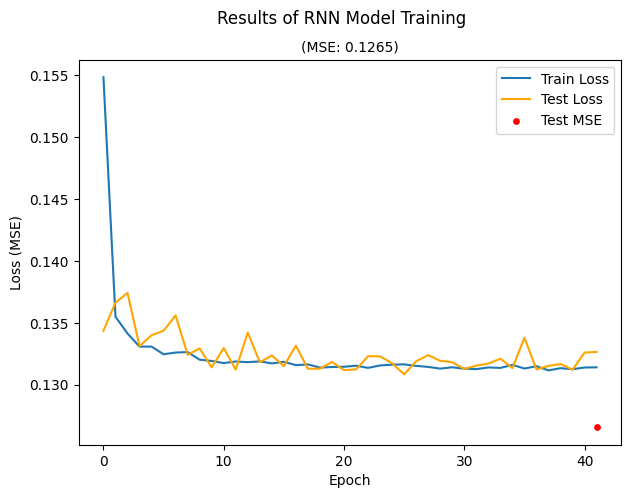

In [29]:
# Plot loss over time, final test stats
plt.figure(figsize=(7, 5))
plt.suptitle("Results of RNN Model Training")
plt.title(f"(MSE: {rnn_test_MSE:.4})", size=10)
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.plot(rnn_log[:], label='Train Loss')
plt.plot(rnn_eval_log[:], label='Test Loss', color='orange')
plt.scatter(x=len(rnn_log)-1, y=rnn_test_MSE, color='r', label="Test MSE", s=15)
plt.legend()
plt.show()

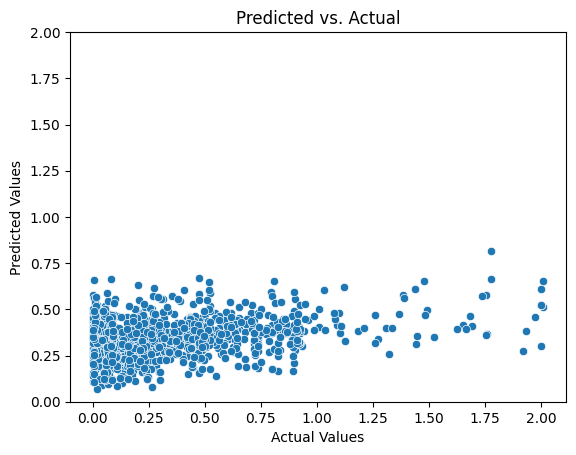

In [18]:
# Plot predicted vs. actual
plt.title("Predicted vs. Actual")
plt.ylabel("Predicted Values")
plt.xlabel("Actual Values")
sns.scatterplot(x=rnn_targets[0:1000], y=rnn_predictions[0:1000])
plt.ylim(0.0, 2.0)
plt.show()

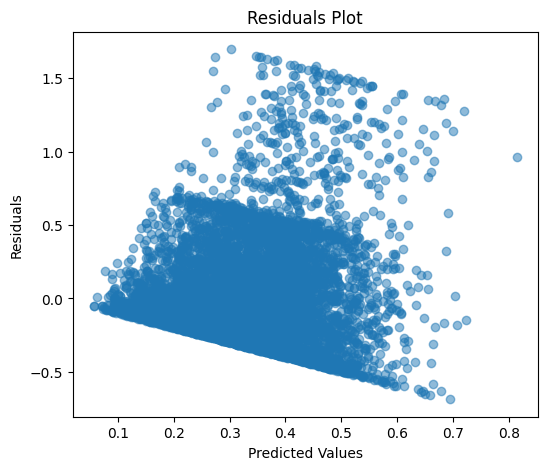

In [19]:
# Plot residuals
plt.figure(figsize=(6, 5))
plt.title("Residuals Plot")
plt.ylabel("Residuals")
plt.xlabel("Predicted Values")
residuals = np.array(rnn_targets) - np.array(rnn_predictions)
plt.scatter(rnn_predictions, residuals, alpha=0.5) 
plt.show()

## Comparing Two models

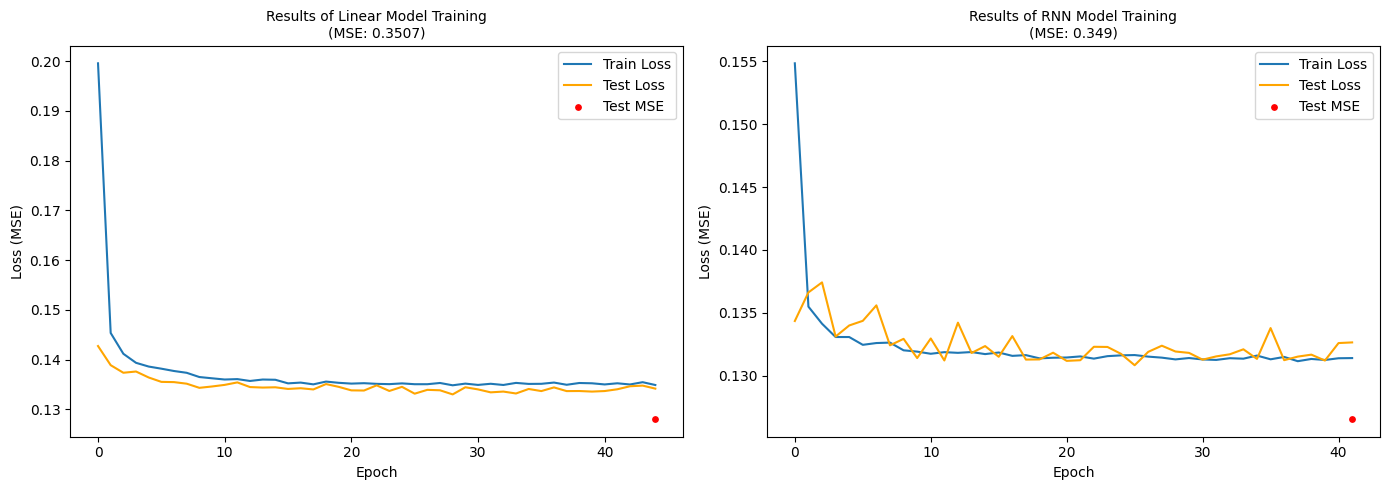

In [30]:
# Create a figure and axis objects for side-by-side plots
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot for the Linear Model Training
ax[0].set_title(f"Results of Linear Model Training\n(MSE: {mlp_test_RMSE:.4})", fontsize=10)
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_xlabel('Epoch')
ax[0].plot(mlp_log, label='Train Loss')
ax[0].plot(mlp_eval_log, label='Test Loss', color='orange')
ax[0].scatter(x=len(mlp_log)-1, y=mlp_test_MSE, color='r', label="Test MSE", s=15)
ax[0].legend()

# Plot for the RNN Model Training
ax[1].set_title(f"Results of RNN Model Training\n(MSE: {rnn_test_RMSE:.4})", fontsize=10)
ax[1].set_ylabel('Loss (MSE)')
ax[1].set_xlabel('Epoch')
ax[1].plot(rnn_log, label='Train Loss')
ax[1].plot(rnn_eval_log, label='Test Loss', color='orange')
ax[1].scatter(x=len(rnn_eval_log)-1, y=rnn_test_MSE, color='r', label="Test MSE", s=15)
ax[1].legend()

# Adjust layout and display
plt.tight_layout()
plt.show()


## Test Evaluation

Showcase how to load models and make predictions using a testing set. Display the predicated values and plot the residuals of all models.

### XGBoost

In [21]:
import xgboost as xgb

# Load trained XGBoost model
best_model = xgb.XGBRegressor()
best_model.load_model('../models/xgboost_model.json')

# Load testing dataset
X_test = pd.read_csv('../models/X_test.csv', index_col=0)
y_test = pd.read_csv('../models/y_test.csv', index_col=0)

In [22]:
# Choose some random values from test set to predict against
inds = np.random.uniform(0, len(X_test), 1000).astype(int)

# Select these values
example_X_test = X_test.iloc[inds]
example_y_true = y_test.iloc[inds]

In [23]:
# Make predictions
example_y_pred = best_model.predict(example_X_test)

# Display predictions and results
print(f"{'True':<10}| {'XGBoost':<10}")
print("-" * 20) 
for i in range(10):
    print(f"{example_y_true.iloc[i].item():<10.3f}| {example_y_pred[i]:<10.3f}")


True      | XGBoost   
--------------------
0.015     | 0.552     
0.176     | 0.308     
0.894     | 0.228     
0.317     | 0.231     
0.173     | 0.253     
1.526     | 0.492     
1.138     | 0.408     
0.102     | 0.382     
0.863     | 0.333     
0.844     | 0.388     


### Neural Networks

In [24]:
# Choose some random values from test set to predict against
inds = np.random.uniform(0, len(test_dataset), 1000).astype(int)

# Select these values
example_input, example_target = test_dataset[list(inds)]
example_input, example_target = example_input.to(DEVICE), example_target.to(DEVICE)  # move to GPU

In [25]:
# Make predictions
simple_baseball_mlp.eval()
baseball_rnn.eval()
example_predictions_mlp = simple_baseball_mlp(example_input)
example_predictions_rnn = baseball_rnn(example_input)

# Display predictions and results
print(f"{'True':<10}| {'MLP':<10}| {'RNN':<10}")
print("-" * 30) 
for i in range(10):
    print(f"{example_target[i].item():<10.3f}| {example_predictions_mlp[i].item():<10.3f}| {example_predictions_rnn[i].item():<10.3f}")

True      | MLP       | RNN       
------------------------------
0.161     | 0.291     | 0.247     
0.124     | 0.382     | 0.377     
0.077     | 0.268     | 0.244     
0.509     | 0.396     | 0.406     
0.080     | 0.437     | 0.497     
0.044     | 0.295     | 0.316     
0.006     | 0.300     | 0.292     
0.149     | 0.328     | 0.288     
0.053     | 0.237     | 0.130     
0.017     | 0.425     | 0.449     


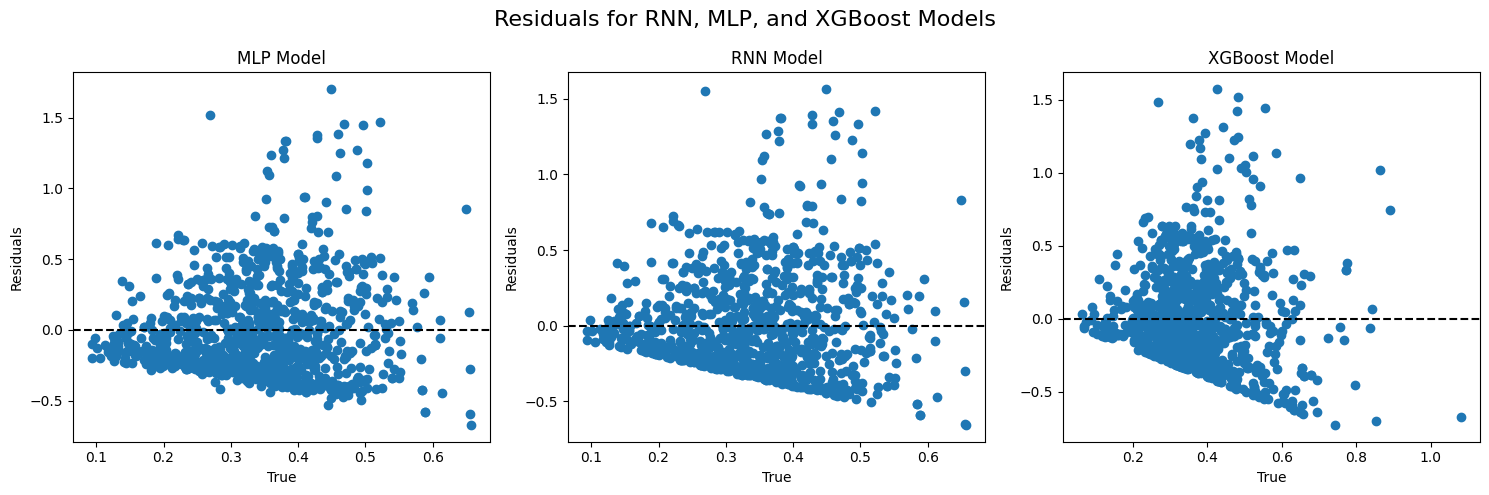

In [26]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

residuals_mlp = example_target.detach().cpu() - example_predictions_mlp.detach().cpu()
axs[0].scatter(example_predictions_rnn.detach().cpu(), residuals_mlp)
axs[0].set_title("MLP Model")
axs[0].set_xlabel("True")
axs[0].set_ylabel("Residuals")
axs[0].axhline(0, color='black', linestyle='--')

residuals_rnn = example_target.detach().cpu() - example_predictions_rnn.detach().cpu()
axs[1].scatter(example_predictions_rnn.detach().cpu(), residuals_rnn)
axs[1].set_title("RNN Model")
axs[1].set_xlabel("True")
axs[1].set_ylabel("Residuals")
axs[1].axhline(0, color='black', linestyle='--')

residuals_xgb = example_y_true.squeeze().to_numpy() - example_y_pred
axs[2].scatter(example_y_pred.squeeze(), residuals_xgb)
axs[2].set_title("XGBoost Model")
axs[2].set_xlabel("True")
axs[2].set_ylabel("Residuals")
axs[2].axhline(0, color='black', linestyle='--')

fig.suptitle("Residuals for RNN, MLP, and XGBoost Models", fontsize=16)

plt.tight_layout()
plt.show()